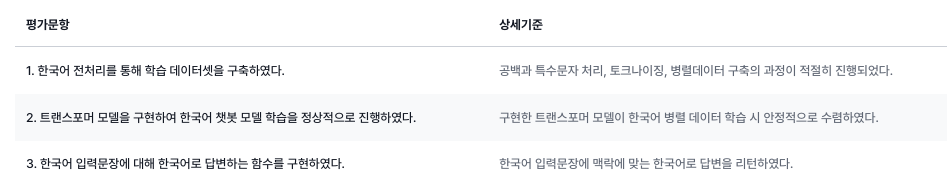

In [1]:
#패키지 호출

import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import konlpy
from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1. 데이터 수집하기

In [2]:
print(os.getcwd())

/aiffel/aiffel/#14_NLP


In [3]:
path = os.getenv("HOME") + '/data/ChatbotData .csv'
data = pd.read_csv(path)
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [5]:
data.isna().sum()

Q        0
A        0
label    0
dtype: int64

- 결측치 없음

# Step 2. 데이터 전처리하기

In [6]:
#구두점 처리
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (가-힣, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [7]:
data['Q'] = data['Q'].apply(preprocess_sentence)
data['A'] = data['A'].apply(preprocess_sentence)

data.head()

,Q,A,label
0,시 땡 !,하루가 또 가네요 .,0
1,지망 학교 떨어졌어,위로해 드립니다 .,0
2,박 일 놀러가고 싶다,여행은 언제나 좋죠 .,0
3,박 일 정도 놀러가고 싶다,여행은 언제나 좋죠 .,0
4,심하네,눈살이 찌푸려지죠 .,0


In [8]:
#형태소 분리
tokenizer = Mecab()

def tokenizing(sentence):
    sentence = tokenizer.morphs(sentence)
    sentence = ' '.join(sentence)
    return sentence

data['Q'] = data['Q'].apply(tokenizing)
data['A'] = data['A'].apply(tokenizing)

data.head()

,Q,A,label
0,시 땡 !,하루 가 또 가 네요 .,0
1,지망 학교 떨어졌 어,위로 해 드립니다 .,0
2,박 일 놀 러 가 고 싶 다,여행 은 언제나 좋 죠 .,0
3,박 일 정도 놀 러 가 고 싶 다,여행 은 언제나 좋 죠 .,0
4,심하 네,눈살 이 찌푸려 지 죠 .,0


[불용어 목록](https://www.ranks.nl/stopwords/korean)

In [9]:
#불용어 처리
file_path = os.getenv('HOME') + '/aiffel/#14_NLP/stopword.txt'
file_path = os.path.expanduser(file_path)  # 홈 디렉토리 확장

# 불용어 리스트 불러오기
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords = [line.strip() for line in file.readlines()]
    return stopwords

# 불용어 리스트 생성
stopwords = load_stopwords(file_path)
len(stopwords)

# 불용어 제거 함수
def remove_stopwords(sentence):
    tokens = sentence.split(' ')
    filtered_tokens = [token for token in tokens if token not in stopwords]
    return ' '.join(filtered_tokens)

# 데이터에 불용어 제거 적용
data['Q'] = data['Q'].apply(remove_stopwords)
data['A'] = data['A'].apply(remove_stopwords)

# 결과 확인
data.head()

,Q,A,label
0,시 땡 !,하루 네요 .,0
1,지망 학교 떨어졌,위로 해 드립니다 .,0
2,박 놀 러 고 싶 다,여행 은 언제나 좋 죠 .,0
3,박 정도 놀 러 고 싶 다,여행 은 언제나 좋 죠 .,0
4,심하,눈살 찌푸려 지 죠 .,0


In [10]:
#단어장 만들기

# 불용어 처리가 완료된 질문과 답변 데이터셋 준비
questions = data['Q'].tolist()
answers = data['A'].tolist()

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print("단어장의 크기:", VOCAB_SIZE)

START_TOKEN의 번호 : [8018]
END_TOKEN의 번호 : [8019]
단어장의 크기: 8020


In [11]:
#단어를 고유 정수로 인코딩 및 패딩

# 각 문장을 토큰화하여 길이를 측정
question_lengths = [len(sentence.split()) for sentence in questions]
answer_lengths = [len(sentence.split()) for sentence in answers]

# 평균 길이와 최대 길이 계산
avg_question_length = sum(question_lengths) / len(question_lengths)
max_question_length = max(question_lengths)
avg_answer_length = sum(answer_lengths) / len(answer_lengths)
max_answer_length = max(answer_lengths)

print(f"질문 평균 길이: {avg_question_length}")
print(f"질문 최대 길이: {max_question_length}")
print(f"답변 평균 길이: {avg_answer_length}")
print(f"답변 최대 길이: {max_answer_length}")

질문 평균 길이: 5.344328850545547
질문 최대 길이: 29
답변 평균 길이: 6.779751332149201
답변 최대 길이: 30


In [12]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 30 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

40
단어장의 크기 : 8020
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [13]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# TensorFlow 텐서로 변환
questions_tensor = tf.convert_to_tensor(questions, dtype=tf.int64)
answers_tensor = tf.convert_to_tensor(answers, dtype=tf.int64)

# 디코더 입력과 타깃 생성
decoder_inputs = answers_tensor[:, :-1]
decoder_targets = answers_tensor[:, 1:]

# 데이터셋 생성
dataset = tf.data.Dataset.from_tensor_slices(({
    'inputs': questions_tensor,
    'dec_inputs': decoder_inputs
}, {
    'outputs': decoder_targets
}))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Step 3. SubwordTextEncoder 사용하기
- 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.



# Step 4. 모델 구성하기

### 1) 포지셔널 인코딩

In [14]:
# 트랜스포머 구축에 필요한 함수 정의

# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### 2) 어텐션

In [15]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [16]:
#멀티헤드 어텐션
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

### 3) 마스킹

In [17]:
# 패딩 마스킹 구현 함수
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

### 4) 인코더

In [18]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [19]:
#인코더 층 쌓아서 인코더 만들기
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 5) 디코더

In [20]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    
  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 6) 모델 정의 및 학습 (트랜스포머 함수)

In [21]:
# 트랜스포머 함수 정의
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [22]:
#모델 생성
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    13574144    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 손실함수

In [23]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [24]:
#커스텀된 학습률(learning rate)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

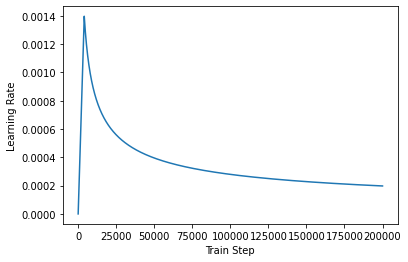

In [25]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 모델 컴파일

In [26]:
#모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### 훈련

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)

EPOCHS = 50
history = model.fit(dataset, epochs=EPOCHS, verbose=1,  callbacks=[early_stopping])

Epoch 1/50
185/185 [==============================] - 71s 220ms/step - loss: 1.4997 - accuracy: 0.0226
Epoch 2/50
185/185 [==============================] - 41s 220ms/step - loss: 1.0197 - accuracy: 0.0515
Epoch 3/50
185/185 [==============================] - 41s 221ms/step - loss: 0.8607 - accuracy: 0.0647
Epoch 4/50
185/185 [==============================] - 41s 220ms/step - loss: 0.7776 - accuracy: 0.0757
Epoch 5/50
185/185 [==============================] - 41s 220ms/step - loss: 0.7179 - accuracy: 0.0825
Epoch 6/50
185/185 [==============================] - 41s 220ms/step - loss: 0.6665 - accuracy: 0.0880
Epoch 7/50
185/185 [==============================] - 41s 220ms/step - loss: 0.6187 - accuracy: 0.0933
Epoch 8/50
185/185 [==============================] - 41s 220ms/step - loss: 0.4910 - accuracy: 0.1087
Epoch 11/50
185/185 [==============================] - 41s 221ms/step - loss: 0.4543 - accuracy: 0.1136
Epoch 12/50
185/185 [==============================] - 41s 220ms/step - 

# Step 5. 모델 평가하기
- Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다

In [28]:
def preprocess_sentence(sentence):
    # SubwordTextEncoder를 사용하여 문장 인코딩
    encoded_sentence = tokenizer.encode(sentence)
    return encoded_sentence
def decoder_inference(sentence):
  # 이미 인코딩된 문장을 받아옴
  sentence = preprocess_sentence(sentence)

  # 입력된 문장에 시작 토큰과 종료 토큰을 앞뒤로 추가
  # ex) [8331, 86, 30, 5, 1059, 7, 8332]
  sentence = tf.expand_dims(
      START_TOKEN + sentence + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
def merge_morphs(morphs):
    sentence = ""
    for morph in morphs:
        # 조사, 어미의 경우 앞 단어와 붙여씁니다.
        if morph.startswith(('을', '를', '이', '가', '은', '는', '와', '과', '로', '에', '어', '아', '다', '요', '.')):
            sentence += morph
        else:
            sentence += " " + morph
    return sentence.strip()

def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  # 형태소 분리된 문장을 자연스러운 문장으로 병합합니다.
  merged_sentence = merge_morphs(predicted_sentence.split())

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(merged_sentence))

  return merged_sentence

In [29]:
sentence_generation('안녕하세요!')

입력 : 안녕하세요!
출력 : 위로 해 드립니다.


'위로 해 드립니다.'

In [30]:
sentence_generation('12시 땡!')

입력 : 12시 땡!
출력 : 전화 해 보 세요.


'전화 해 보 세요.'

In [31]:
sentence_generation('1지망 학교 떨어졌어')

입력 : 1지망 학교 떨어졌어
출력 : 위로 해 드립니다.


'위로 해 드립니다.'

# 회고

- 출력 결과가 요상하다
- 정확도가 18%로 너무 낮게 나오는데, 이거 어떻게 개선하는지는 좀 더 공부해봐야겠다.